In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import datetime as dt
import seaborn as sn
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [2]:
sx = pdr.get_data_yahoo("^STOXX50E", start="2018-01-01", end="2021-04-09")
sp = pdr.get_data_yahoo("^GSPC", start="2018-01-01", end="2021-04-09")
sm = pdr.get_data_yahoo("^SSMI", start="2018-01-01", end="2021-04-09")

In [3]:
# sx.head()

In [4]:
# sp.head()

In [5]:
# sx.tail()

In [3]:
basket = pd.DataFrame()
basket["sx_close"] = sx['Close'].pct_change().dropna()
basket["sp_close"] = sp['Close'].pct_change().dropna()
basket["sm_close"] = sm['Close'].pct_change().dropna()

In [7]:
# interest rate, dividend yield rates, volatilities, correlations

In [5]:
corr_mat = basket.corr() # correlation of returns

In [6]:
# find yearly expected stock returns for each underlying asset

mu_sx = np.mean(np.log(1 + sx['Close'].pct_change().dropna()))*252
mu_sp = np.mean(np.log(1 + sp['Close'].pct_change().dropna()))*252
mu_sm = np.mean(np.log(1 + sm['Close'].pct_change().dropna()))*252
print("returns EURO STOXX 50: ", mu_sx)
print("returns S&P 500: ", mu_sp)
print("returns Swiss Market index: ", mu_sm)

print()

# find annualized stock volatility for each underlying asset

sig_sx = np.std(np.log(1 + sx['Close'].pct_change().dropna()))*(252**.5)
sig_sp = np.std(np.log(1 + sp['Close'].pct_change().dropna()))*(252**.5)
sig_sm = np.std(np.log(1 + sm['Close'].pct_change().dropna()))*(252**.5)

print("volatility EURO STOXX 50: ", sig_sx)
print("volatility S&P 500: ", sig_sp)
print("volatility Swiss Market index: ", sig_sm)

returns EURO STOXX 50:  0.03868169961915422
returns S&P 500:  0.13068683917499704
returns Swiss Market index:  0.052844506759975235

volatility EURO STOXX 50:  0.21242074732378197
volatility S&P 500:  0.22923880677619787
volatility Swiss Market index:  0.1699003001958509


In [7]:
d_sx = 1.72/100 # https://www.marketbeat.com/stocks/NYSEARCA/FEZ/dividend/
d_sp = 1.45/100 # https://ycharts.com/indicators/sp_500_dividend_yield
d_sm = 2.31/100 # http://www.dividendsranking.com/Index/SMI.php

print("divident yield EURO STOXX 50: ", d_sx)
print("divident yield S&P 500: ", d_sp)
print("divident yield Swiss Market index: ", d_sm)

divident yield EURO STOXX 50:  0.0172
divident yield S&P 500:  0.014499999999999999
divident yield Swiss Market index:  0.0231


In [22]:
T = 2
r = 0.01 # the risk free rate is about 1% based on google source
n = 2*252 # 8 quarters
dt = T/(2*252)
N = 10**5
C = np.linalg.cholesky(corr_mat)

# dt_vec = np.array([(dt)*252, (dt)*63, (dt)*63, (dt)*63, (dt)*63])
# n = 5

X_sx=np.zeros((N,int(n)+1))
X_sx[:,0]=sx['Close'][-1]

X_sp=np.zeros((N,int(n)+1))
X_sp[:,0]=sp['Close'][-1]

X_sm=np.zeros((N,int(n)+1))
X_sm[:,0]=sm['Close'][-1]

In [23]:
coup = 6.25
denom = 1000;
init_fix = np.array([3857.07, 3917.45, 11130.28])
tl = np.array([0.95, 0.85, 0.75, 0.65, 0.59])
br = np.zeros((5,3))
for i in range(0,5):
  br[i,:] = init_fix*tl[i]
obs = np.array([251])
obs = np.append(obs, obs[-1]+63)
obs = np.append(obs, obs[-1]+63)
obs = np.append(obs, obs[-1]+63)
obs = np.append(obs, obs[-1]+63)

In [24]:
for i in range(1,n+1):
  W = np.random.normal(0, 1, (N,3))
  Z=np.matmul(W,C);    #W*C;

  X_sx[:,i] = X_sx[:,i-1]*np.exp((mu_sx - d_sx - (sig_sx**2)/2)*dt + sig_sx*np.sqrt(dt)*Z[:,0])
  X_sp[:,i] = X_sp[:,i-1]*np.exp((mu_sp - d_sp - (sig_sp**2)/2)*dt + sig_sp*np.sqrt(dt)*Z[:,1])
  X_sm[:,i] = X_sm[:,i-1]*np.exp((mu_sm - d_sm - (sig_sm**2)/2)*dt + sig_sm*np.sqrt(dt)*Z[:,2])

In [25]:
def calculatePayoff(X_sx, X_sp, X_sm, N, coup):
  payoff = np.ones(N)*coup*(np.exp(-r*63/252)+np.exp(-r*2*63/252)+np.exp(-r*3*63/252))
  for i in range(0, N):
    for j in range(0,len(obs)):
      if(X_sx[i,obs[j]] > br[j,0] and X_sp[i,obs[j]] > br[j,1] and X_sm[i,obs[j]] > br[j,2]):
        if(j != 4):
          payoff[i] += np.exp(-r*obs[j]/252)*(coup + denom);
        else:
          perf = [X_sx[i,obs[j]]/init_fix[0], X_sp[i,obs[j]]/init_fix[1], X_sm[i,obs[j]]/init_fix[2]]
          worst = np.min(perf)
          payoff[i] += np.exp(-r*obs[j]/252)*(coup + denom*worst)
        break;
      else:
        if(j == 4):
          payoff[i] += np.exp(-r*obs[j]/252)*(coup + denom)
        else:
          payoff[i] += np.exp(-r*obs[j]/252)*(coup)

  return payoff
        

In [26]:
payoff = calculatePayoff(X_sx, X_sp, X_sm, N, 6.25)

In [27]:
print("Fair Price (mean) for",N,"simulations:", np.mean(payoff))

Fair Price (mean) for 100000 simulations: 1008.3029412938826


In [28]:
print("Standard Error of Estimator for",N,"simulations:",np.std(payoff)/N)

Standard Error of Estimator for 100000 simulations: 0.000568584774793711


In [ ]:
coupon_rates = np.linspace(0, 10, 100, endpoint=True)*250/100

In [ ]:
prices = np.array([])
for cpr in coupon_rates[1:]:
  prices = np.append(prices, np.mean(calculatePayoff(X_sx, X_sp, X_sm, N, cpr)))

In [ ]:
crVp = pd.DataFrame()
crVp['coupon_rates'] = coupon_rates[1:]*100/250
crVp['fair_price'] = prices

Text(0.5, 1.0, 'Coupon Rate vs Fair Price')

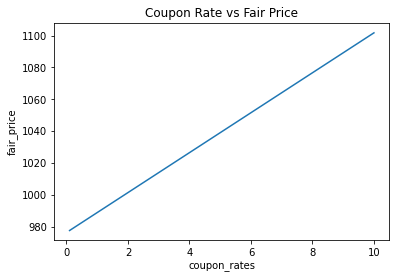

In [ ]:
ax = sns.lineplot(data=crVp, x="coupon_rates", y="fair_price")
ax.set_title('Coupon Rate vs Fair Price')

In [27]:
N = 10**5

In [28]:
## Anti-thetic variates method 
X_sx1=np.zeros((int(N/2),int(n)+1))
X_sx1[:,0]=sx['Close'][-1]

X_sp1=np.zeros((int(N/2),int(n)+1))
X_sp1[:,0]=sp['Close'][-1]

X_sm1=np.zeros((int(N/2),int(n)+1))
X_sm1[:,0]=sm['Close'][-1]

X_sx2=np.zeros((int(N/2),int(n)+1))
X_sx2[:,0]=sx['Close'][-1]

X_sp2=np.zeros((int(N/2),int(n)+1))
X_sp2[:,0]=sp['Close'][-1]

X_sm2=np.zeros((int(N/2),int(n)+1))
X_sm2[:,0]=sm['Close'][-1]

In [29]:
for i in range(1,n+1):
  W1 = np.random.normal(0, 1, (int(N/2),3))
  Z1=np.matmul(W1,C)    #W*C;
  Z2=-1*Z1
  X_sx1[:,i] = X_sx1[:,i-1]*np.exp((mu_sx - d_sx - (sig_sx**2)/2)*dt + sig_sx*np.sqrt(dt)*Z1[:,0])
  X_sp1[:,i] = X_sp1[:,i-1]*np.exp((mu_sp - d_sp - (sig_sp**2)/2)*dt + sig_sp*np.sqrt(dt)*Z1[:,1])
  X_sm1[:,i] = X_sm1[:,i-1]*np.exp((mu_sm - d_sm - (sig_sm**2)/2)*dt + sig_sm*np.sqrt(dt)*Z1[:,2])

  X_sx2[:,i] = X_sx2[:,i-1]*np.exp((mu_sx - d_sx - (sig_sx**2)/2)*dt + sig_sx*np.sqrt(dt)*Z2[:,0])
  X_sp2[:,i] = X_sp2[:,i-1]*np.exp((mu_sp - d_sp - (sig_sp**2)/2)*dt + sig_sp*np.sqrt(dt)*Z2[:,1])
  X_sm2[:,i] = X_sm2[:,i-1]*np.exp((mu_sm - d_sm - (sig_sm**2)/2)*dt + sig_sm*np.sqrt(dt)*Z2[:,2])


In [30]:
payoff1 = calculatePayoff(X_sx1, X_sp1, X_sm1 , int(N/2), 6.25)
payoff2 = calculatePayoff(X_sx2, X_sp2, X_sm2, int(N/2),  6.25)

total_payoff = np.append(payoff1, payoff2)

In [31]:
print("Fair Price (mean) for",N,"simulations:", np.mean(total_payoff))

Fair Price (mean) for 100000 simulations: 1007.5883071066914


In [32]:
print("Standard Error of Estimator for",N,"simulations:",np.std(total_payoff)/N)

Standard Error of Estimator for 100000 simulations: 0.0005874778721003061


In [ ]:
type(payoff1)

numpy.ndarray

In [ ]:
# Apply the standard Monte-Carlo method to price 
# plot the contract as the function of coupon rate
# Report mean and variance. Make use of some variance reduction method for which report mean and variance as well. 

In [ ]:
## Defing payoff function for ABRC for a single underlying asset
def calculatePayoff_single(X_sx, N, coup):
  payoff = np.ones(N)*coup*(np.exp(-r*63/252)+np.exp(-r*2*63/252)+np.exp(-r*3*63/252))
  for i in range(0, N):
    for j in range(0,len(obs)):
      if(X_sx[i,obs[j]] > br[j,0]):
        if(j != 4):
          payoff[i] += np.exp(-r*obs[j]/252)*(coup + denom);
        else:
          worst = X_sx[i,obs[j]]/init_fix[0]
          payoff[i] += np.exp(-r*obs[j]/252)*(coup + denom*worst)
        break;
      else:
        if(j == 4):
          payoff[i] += np.exp(-r*obs[j]/252)*(coup + denom)
        else:
          payoff[i] += np.exp(-r*obs[j]/252)*(coup)

  return payoff

In [ ]:
## apply control variate method
s_payoff = calculatePayoff_single(X_sx, N, coup)
b=np.corrcoef(payoff,s_payoff)[0,1]
payoff_cv = payoff - b*(s_payoff - np.mean(s_payoff))
print("(Control Variates) Fair Price (mean) for",N,"simulations:", np.mean(payoff_cv))
print("(Control Variates) Standard Error of Estimator for",N,"simulations:",np.std(payoff_cv/N))